# Universidad Internacional del Ecuador  
## Procesamiento de Imágenes y Señales  
### Deber 2 — Semana 2 (FFT y Filtros)

**Grupo 6**  
- DARIO WLADIMIR HERRERA CHÁVEZ  
- JONATHAN FABRICIO GUALLI RAMIREZ  
- JORGE ARMANDO QUIZAMANCHURO FUEL  

---

## Notebook 01: Comparación de Filtros IIR vs FIR en Voz con Ruido Blanco

En este notebook se realiza lo siguiente:

1. **Carga de audio de voz limpia** (`voz_limpia.wav`) y conversión a mono.
2. **Generación de ruido blanco artificial** para obtener una señal de voz con ruido a un SNR definido.
3. Diseño y prueba de **múltiples filtros pasa-banda**:
   - **IIR** (Butterworth, Chebyshev, Elliptic)
   - **FIR** (ventana Hamming y Kaiser)
4. Evaluación mediante métricas objetivas para seleccionar el mejor filtro:
   - **SNR (dB)** con referencia a la voz limpia
   - **Relación de energía dentro/fuera de banda** (dB)

📌 **Nota**  
Ejecuta el notebook en orden secuencial para asegurar que las funciones y variables estén disponibles.

🔗 **Link Repositorio:** https://github.com/georgenton/UIDE-Procesamiento-Imagenes-Senales-Deber-2


##  Imports

In [1]:
import sys
import os

# Agregar la carpeta raíz del proyecto al path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root añadido:", project_root)
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from src.dsp_filters import (
    normalize_audio,
    design_iir_bandpass, apply_iir,
    design_fir_bandpass, apply_fir
)
from src.metrics import snr_db, band_energy_ratio_db


Project root añadido: /Users/georgenton/Documents/Proyectos/UIDE/UIDE-Procesamiento-Imagenes-Senales-Deber-2


## 2 Cargar voz limpia

In [2]:
clean_path = "../data/raw/voz_limpia.wav"
x_clean, fs = sf.read(clean_path)
if x_clean.ndim > 1:
    x_clean = x_clean[:, 0]
x_clean = normalize_audio(x_clean)

print("fs:", fs, "duración(s):", len(x_clean)/fs)


fs: 44100 duración(s): 10.65795918367347


## 3 Crear ruido blanco artificial (SNR objetivo)

In [3]:
snr_target_db = 0.0  # prueba 0 dB y luego 5 dB para comparar
rng = np.random.default_rng(0)

noise = rng.normal(0, 1, size=len(x_clean)).astype(np.float32)

p_clean = np.mean(x_clean**2)
p_noise = np.mean(noise**2)

k = np.sqrt(p_clean / (p_noise * (10**(snr_target_db/10))))
x_noisy = x_clean + k*noise
x_noisy = normalize_audio(x_noisy)

sf.write("../data/processed/voz_ruido_blanco.wav", x_noisy, fs)


## 4 Filtros a probar (mínimo 4, aquí tendrás 5)

In [4]:
band = (300.0, 3400.0)

filters = [
    ("IIR_Butter_o4", ("iir", "butter", 4)),
    ("IIR_Cheby1_o5", ("iir", "cheby1", 5)),
    ("IIR_Ellip_o5", ("iir", "ellip", 5)),
    ("FIR_Hamming_401", ("fir", "hamming", 401)),
    ("FIR_Kaiser_801", ("fir", ("kaiser", 8.0), 801)),
]


##  5 Filtrar + métricas + guardar

In [5]:
results = []

for name, spec in filters:
    if spec[0] == "iir":
        _, kind, order = spec
        b, a = design_iir_bandpass(fs, band[0], band[1], kind=kind, order=order, rp=1.0, rs=40.0)
        y = apply_iir(x_noisy, b, a, zero_phase=True)
    else:
        _, window, ntaps = spec
        taps = design_fir_bandpass(fs, band[0], band[1], ntaps=ntaps, window=window)
        y = apply_fir(x_noisy, taps)

    y = normalize_audio(y)

    snr_out = snr_db(x_clean, y)
    ber = band_energy_ratio_db(y, fs, band)

    results.append((name, snr_out, ber))
    sf.write(f"../data/processed/{name}.wav", y, fs)

results_sorted = sorted(results, key=lambda t: (t[1], t[2]), reverse=True)
results_sorted


[('IIR_Butter_o4',
  np.float64(-0.5157807604959946),
  np.float64(15.98908641451294)),
 ('IIR_Cheby1_o5',
  np.float64(-0.7512975418189738),
  np.float64(16.554198986115733)),
 ('IIR_Ellip_o5',
  np.float64(-0.8405076059741757),
  np.float64(19.734821291448313)),
 ('FIR_Hamming_401',
  np.float64(-2.0039674479739573),
  np.float64(15.472504984847383)),
 ('FIR_Kaiser_801',
  np.float64(-2.3704922615121022),
  np.float64(19.088421871685643))]

## 6 Graficar comparación del “mejor”

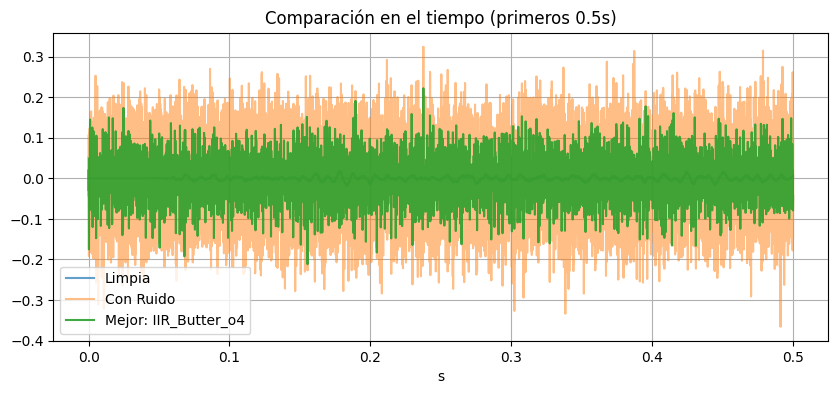

In [6]:
best_name = results_sorted[0][0]
best_path = f"../data/processed/{best_name}.wav"
y_best, _ = sf.read(best_path)
if y_best.ndim > 1: y_best = y_best[:,0]

t = np.arange(len(x_clean)) / fs
plt.figure(figsize=(10,4))
plt.plot(t[:int(0.5*fs)], x_clean[:int(0.5*fs)], label="Limpia", alpha=0.7)
plt.plot(t[:int(0.5*fs)], x_noisy[:int(0.5*fs)], label="Con Ruido", alpha=0.5)
plt.plot(t[:int(0.5*fs)], y_best[:int(0.5*fs)], label=f"Mejor: {best_name}", alpha=0.9)
plt.title("Comparación en el tiempo (primeros 0.5s)")
plt.xlabel("s")
plt.grid(True)
plt.legend()
plt.show()
